In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#export
from exp.nb_10 import *

In [3]:
path = untar_data(imagenette_160); path

PosixPath('/home/ubuntu/learnai/dl/data/imagenette-160')

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

# Mixup

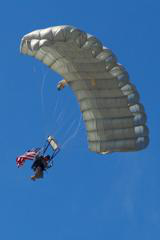

In [5]:
img1 = PIL.Image.open(ll.train.x.items[0])
img1

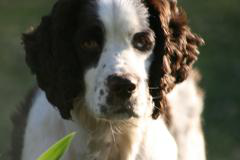

In [6]:
img2 = PIL.Image.open(ll.train.x.items[4000])
img2

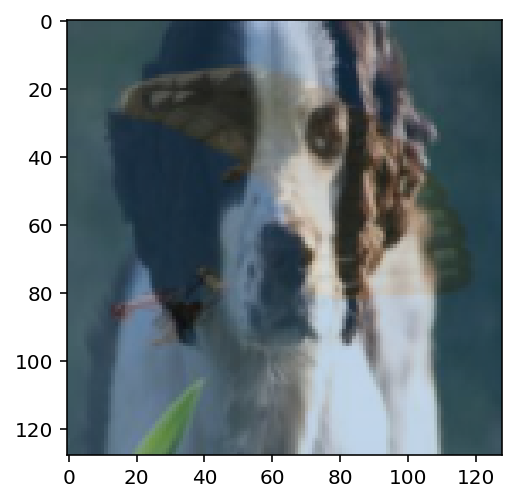

In [7]:
mixed_up = ll.train.x[0] * 0.3 + ll.train.x[4000] * 0.7
plt.imshow(mixed_up.permute(1,2,0));

In [8]:
gamma = lambda x:x.lgamma().exp()

In [9]:
facts = [math.factorial(i) for i in range(7)]

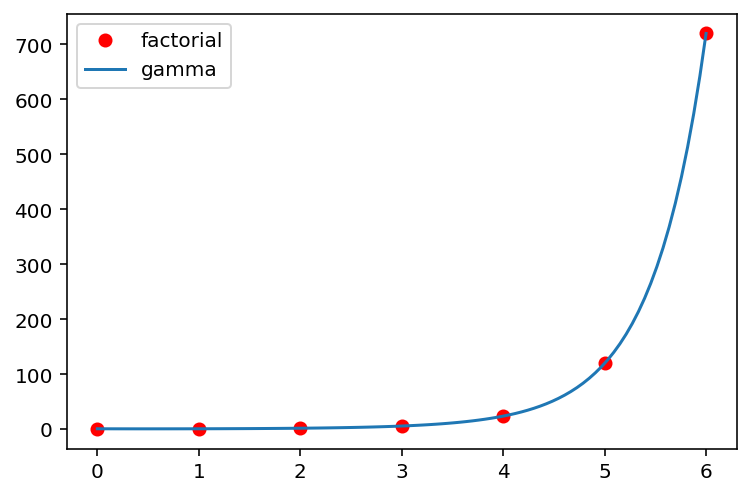

In [10]:
plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), gamma(torch.linspace(0,6)+1))
plt.legend(['factorial', 'gamma']);

In [11]:
torch.linspace(0, 0.9, 10)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])

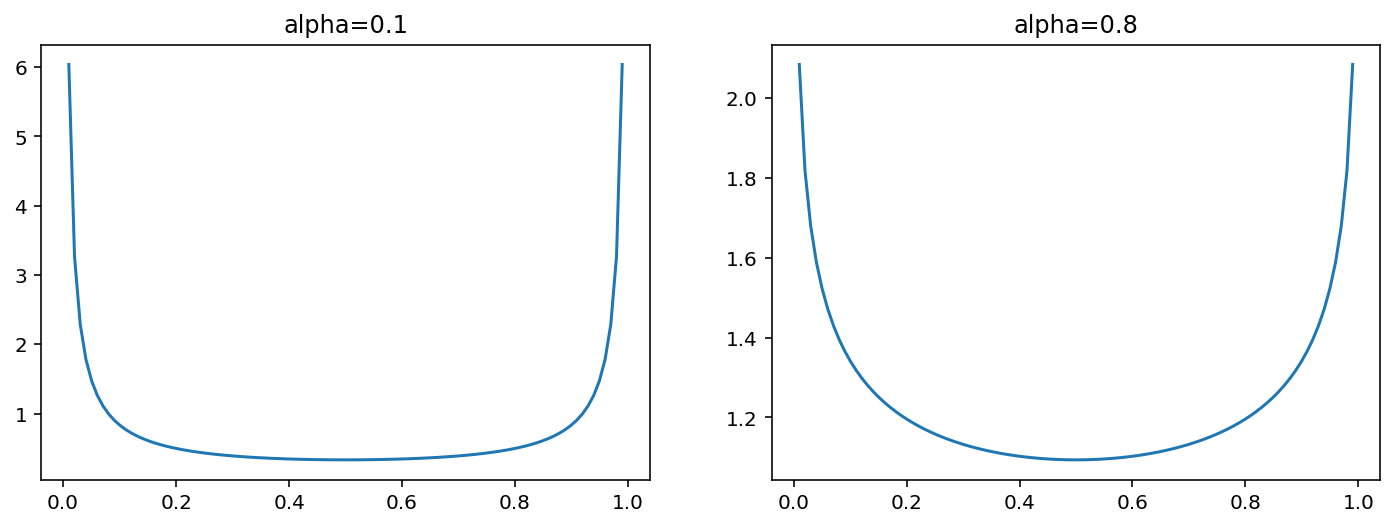

In [12]:
_, axs = plt.subplots(1, 2, figsize=(12,4))
x = torch.linspace(0, 1, 100)
for alpha, ax in zip([0.1, 0.8], axs):
    alpha = tensor(alpha)
    y = (x**(alpha - 1) * (1 - x)**(alpha - 1)) / (gamma(alpha**2) / gamma(alpha))
    ax.plot(x, y)
    ax.set_title(f'alpha={alpha:.1}')

In [13]:
#export
class NoneReduce():
    def __init__(self, loss_func):
        self.loss_func, self.old_red = loss_func, None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else:
            return partial(self.loss_func, reduction='none')
    
    def __exit__(self, type, value, traceback):
        if self.old_red is not None:
            setattr(self.loss_func, 'reduction', self.old_red)

In [14]:
#export
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims):
        input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    if reduction=='mean':
        return loss.mean()
    elif reduction=='sum':
        return loss.sum()
    else:
        return loss

In [15]:
#export
class MixUp(Callback):
    _order = 90
    def __init__(self, alpha=0.4):
        self.distrib = Beta(tensor([alpha]), tensor([alpha]))
        
    def begin_fit(self):
        self.old_loss_func, self.run.loss_func = self.run.loss_func, self.loss_func
        
    def begin_batch(self):
        if not self.in_train:
            return
        
        lamb = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        lamb = torch.stack([lamb, 1-lamb], 1)
        self.lamb = unsqueeze(lamb.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1, self.yb1 = self.xb[shuffle], self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.lamb)
        
    def after_fit(self):
        self.run.loss_func = self.old_loss_func
        
    def loss_func(self, pred, yb):
        if not self.in_train:
            return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.lamb)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [16]:
nfs = [32, 64, 128, 256, 512]

In [17]:
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
               cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [18]:
cbfs = [partial(AvgStatsCallback, accuracy),
       CudaCallback,
       ProgressCallback,
       partial(BatchTransformXCallback, norm_imagenette),
       MixUp]

In [19]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [20]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.922642,0.229564,2.014923,0.354000,00:16


In [21]:
#export
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super().__init__()
        self.eps, self.reduction = eps, reduction
        
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.eps)

In [22]:
cbfs = [partial(AvgStatsCallback, accuracy),
       CudaCallback,
       ProgressCallback,
       partial(BatchTransformXCallback, norm_imagenette)]

In [23]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs, loss_func=LabelSmoothingCrossEntropy())

In [24]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.936681,0.283931,3.332135,0.320000,00:15


In [25]:
assert learn.loss_func.reduction == 'mean'

# Export

In [26]:
!python notebook2script.py 10b_mixup_label_smoothing.ipynb

converted 10b_mixup_label_smoothing.ipynb to nb_10b.py
